In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('FINAL_data2.csv')
df.drop(columns=['word_count'], inplace=True)
df.rename(columns={'dialect': 'labels'}, inplace=True)

In [ ]:
set(df.labels.values)

In [ ]:
names={'Egyptian':0, 'Iraqi':1, 'Khaleeji':2, 'Levantine':3, 'Lybia':4, 'Maghrebi':5, 'Sudani':6}


In [ ]:
df['labels'] = df['labels'].map(names)
df['labels'] = df['labels'].astype('int')

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['labels'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['labels']
)

In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels})
datasets = DatasetDict({"train": train_dataset, "validation": val_dataset})

In [ ]:
araberttokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")
model = AutoModelForSequenceClassification.from_pretrained("UBC-NLP/MARBERTv2", num_labels=7)

In [ ]:
lora_config = LoraConfig(
    r=16,                        # Low-rank factor
    lora_alpha=16,              # Scaling
    target_modules=["query","key","value","dense"],
    lora_dropout=0.2,               # Common for BERT attention layers # Regularization
    bias="none",
    task_type=TaskType.SEQ_CLS # For classification
)
peft_model = get_peft_model(model, 
                            lora_config)

In [ ]:
# Tokenize all text entries
tokenized_inputs = araberttokenizer(
    list(train_dataset['text']),    
    padding=True,
    max_length=16,                       
    truncation=False,                     
    return_tensors='pt'                   
)
labels = torch.tensor(train_dataset['labels'])

In [ ]:
tokenized_inputs_val = araberttokenizer(
    list(val_dataset['text']),                   
    padding=True,      
    max_length=16,                  
    truncation=False,                     
    return_tensors='pt'                    
)
labels_val = torch.tensor(val_dataset['labels'])

In [ ]:
from torch.utils.data import Dataset

class BERTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item


In [ ]:
dataset = BERTDataset(tokenized_inputs, labels)
val_dataset = BERTDataset(tokenized_inputs_val, labels_val)

In [ ]:
peft_model = get_peft_model(model, 
                            lora_config)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
    }

In [ ]:
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2
)

In [ ]:
peft_training_args = TrainingArguments(
    output_dir="./Forth_trial/model",
    auto_find_batch_size=True,
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    fp16=True  
)
    
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [26]:
peft_trainer.train()

 85%|████████▍ | 21301/25184 [51:19<07:27,  8.67it/s]

{'loss': 0.5023, 'learning_rate': 7.731099110546379e-05, 'epoch': 3.38}


 85%|████████▍ | 21351/25184 [51:25<07:06,  8.98it/s]

{'loss': 0.449, 'learning_rate': 7.631829733163914e-05, 'epoch': 3.39}


 85%|████████▍ | 21401/25184 [51:30<06:43,  9.37it/s]

{'loss': 0.4619, 'learning_rate': 7.532560355781449e-05, 'epoch': 3.4}


 85%|████████▌ | 21451/25184 [51:35<06:32,  9.52it/s]

{'loss': 0.4413, 'learning_rate': 7.433290978398984e-05, 'epoch': 3.41}


 85%|████████▌ | 21502/25184 [51:41<06:32,  9.37it/s]

{'loss': 0.4611, 'learning_rate': 7.334021601016518e-05, 'epoch': 3.41}


 86%|████████▌ | 21551/25184 [51:46<06:34,  9.21it/s]

{'loss': 0.455, 'learning_rate': 7.234752223634053e-05, 'epoch': 3.42}


 86%|████████▌ | 21601/25184 [51:52<06:31,  9.16it/s]

{'loss': 0.5053, 'learning_rate': 7.135482846251588e-05, 'epoch': 3.43}


 86%|████████▌ | 21652/25184 [51:57<06:02,  9.73it/s]

{'loss': 0.5042, 'learning_rate': 7.036213468869123e-05, 'epoch': 3.44}


 86%|████████▌ | 21701/25184 [52:02<06:01,  9.62it/s]

{'loss': 0.5516, 'learning_rate': 6.936944091486658e-05, 'epoch': 3.45}


 86%|████████▋ | 21751/25184 [52:08<05:48,  9.84it/s]

{'loss': 0.432, 'learning_rate': 6.837674714104193e-05, 'epoch': 3.45}


 87%|████████▋ | 21802/25184 [52:13<05:53,  9.57it/s]

{'loss': 0.4782, 'learning_rate': 6.738405336721728e-05, 'epoch': 3.46}


 87%|████████▋ | 21851/25184 [52:19<06:00,  9.26it/s]

{'loss': 0.4616, 'learning_rate': 6.639135959339263e-05, 'epoch': 3.47}


 87%|████████▋ | 21901/25184 [52:24<06:29,  8.42it/s]

{'loss': 0.4853, 'learning_rate': 6.539866581956798e-05, 'epoch': 3.48}


 87%|████████▋ | 21951/25184 [52:30<05:40,  9.49it/s]

{'loss': 0.5211, 'learning_rate': 6.440597204574333e-05, 'epoch': 3.49}


 87%|████████▋ | 22000/25184 [52:36<06:01,  8.80it/s]

{'loss': 0.4909, 'learning_rate': 6.341327827191868e-05, 'epoch': 3.49}


 88%|████████▊ | 22051/25184 [52:42<06:07,  8.53it/s]

{'loss': 0.5153, 'learning_rate': 6.242058449809402e-05, 'epoch': 3.5}


 88%|████████▊ | 22101/25184 [52:48<06:00,  8.56it/s]

{'loss': 0.4563, 'learning_rate': 6.142789072426939e-05, 'epoch': 3.51}


 88%|████████▊ | 22151/25184 [52:53<05:42,  8.85it/s]

{'loss': 0.4356, 'learning_rate': 6.043519695044473e-05, 'epoch': 3.52}


 88%|████████▊ | 22201/25184 [52:59<05:45,  8.64it/s]

{'loss': 0.4266, 'learning_rate': 5.944250317662007e-05, 'epoch': 3.53}


 88%|████████▊ | 22251/25184 [53:04<05:40,  8.62it/s]

{'loss': 0.4877, 'learning_rate': 5.844980940279543e-05, 'epoch': 3.53}


 89%|████████▊ | 22301/25184 [53:10<05:20,  8.98it/s]

{'loss': 0.4255, 'learning_rate': 5.7457115628970776e-05, 'epoch': 3.54}


 89%|████████▉ | 22352/25184 [53:16<05:10,  9.13it/s]

{'loss': 0.452, 'learning_rate': 5.6464421855146125e-05, 'epoch': 3.55}


 89%|████████▉ | 22401/25184 [53:21<05:06,  9.07it/s]

{'loss': 0.4216, 'learning_rate': 5.5471728081321474e-05, 'epoch': 3.56}


 89%|████████▉ | 22451/25184 [53:27<05:44,  7.94it/s]

{'loss': 0.4931, 'learning_rate': 5.4479034307496823e-05, 'epoch': 3.57}


 89%|████████▉ | 22501/25184 [53:34<05:25,  8.25it/s]

{'loss': 0.4569, 'learning_rate': 5.348634053367218e-05, 'epoch': 3.57}


 90%|████████▉ | 22551/25184 [53:40<05:14,  8.36it/s]

{'loss': 0.4723, 'learning_rate': 5.249364675984752e-05, 'epoch': 3.58}


 90%|████████▉ | 22601/25184 [53:46<05:15,  8.19it/s]

{'loss': 0.4606, 'learning_rate': 5.150095298602287e-05, 'epoch': 3.59}


 90%|████████▉ | 22651/25184 [53:52<05:00,  8.42it/s]

{'loss': 0.4735, 'learning_rate': 5.0508259212198226e-05, 'epoch': 3.6}


 90%|█████████ | 22701/25184 [53:57<04:43,  8.77it/s]

{'loss': 0.4374, 'learning_rate': 4.951556543837357e-05, 'epoch': 3.61}


 90%|█████████ | 22752/25184 [54:03<04:22,  9.26it/s]

{'loss': 0.5127, 'learning_rate': 4.852287166454892e-05, 'epoch': 3.61}


 91%|█████████ | 22801/25184 [54:08<04:23,  9.05it/s]

{'loss': 0.5253, 'learning_rate': 4.7530177890724274e-05, 'epoch': 3.62}


 91%|█████████ | 22851/25184 [54:14<04:16,  9.08it/s]

{'loss': 0.4934, 'learning_rate': 4.653748411689962e-05, 'epoch': 3.63}


 91%|█████████ | 22901/25184 [54:20<04:22,  8.71it/s]

{'loss': 0.475, 'learning_rate': 4.5544790343074965e-05, 'epoch': 3.64}


 91%|█████████ | 22951/25184 [54:26<04:25,  8.41it/s]

{'loss': 0.4746, 'learning_rate': 4.455209656925032e-05, 'epoch': 3.65}


 91%|█████████▏| 23001/25184 [54:32<04:13,  8.61it/s]

{'loss': 0.4315, 'learning_rate': 4.355940279542567e-05, 'epoch': 3.65}


 92%|█████████▏| 23051/25184 [54:38<04:33,  7.79it/s]

{'loss': 0.5483, 'learning_rate': 4.256670902160101e-05, 'epoch': 3.66}


 92%|█████████▏| 23101/25184 [54:44<04:08,  8.39it/s]

{'loss': 0.5198, 'learning_rate': 4.157401524777637e-05, 'epoch': 3.67}


 92%|█████████▏| 23151/25184 [54:50<03:46,  8.99it/s]

{'loss': 0.513, 'learning_rate': 4.058132147395172e-05, 'epoch': 3.68}


 92%|█████████▏| 23201/25184 [54:56<04:03,  8.16it/s]

{'loss': 0.4556, 'learning_rate': 3.958862770012706e-05, 'epoch': 3.68}


 92%|█████████▏| 23251/25184 [55:02<03:56,  8.17it/s]

{'loss': 0.4757, 'learning_rate': 3.8595933926302415e-05, 'epoch': 3.69}


 93%|█████████▎| 23301/25184 [55:08<03:48,  8.25it/s]

{'loss': 0.4912, 'learning_rate': 3.7603240152477764e-05, 'epoch': 3.7}


 93%|█████████▎| 23351/25184 [55:14<03:33,  8.58it/s]

{'loss': 0.4617, 'learning_rate': 3.661054637865311e-05, 'epoch': 3.71}


 93%|█████████▎| 23401/25184 [55:20<03:32,  8.41it/s]

{'loss': 0.474, 'learning_rate': 3.561785260482846e-05, 'epoch': 3.72}


 93%|█████████▎| 23451/25184 [55:26<03:03,  9.44it/s]

{'loss': 0.543, 'learning_rate': 3.462515883100381e-05, 'epoch': 3.72}


 93%|█████████▎| 23501/25184 [55:32<03:24,  8.25it/s]

{'loss': 0.4617, 'learning_rate': 3.363246505717917e-05, 'epoch': 3.73}


 94%|█████████▎| 23551/25184 [55:38<03:07,  8.70it/s]

{'loss': 0.4818, 'learning_rate': 3.263977128335451e-05, 'epoch': 3.74}


 94%|█████████▎| 23601/25184 [55:44<03:16,  8.04it/s]

{'loss': 0.4767, 'learning_rate': 3.164707750952986e-05, 'epoch': 3.75}


 94%|█████████▍| 23651/25184 [55:50<02:50,  8.97it/s]

{'loss': 0.4799, 'learning_rate': 3.065438373570521e-05, 'epoch': 3.76}


 94%|█████████▍| 23701/25184 [55:56<02:40,  9.23it/s]

{'loss': 0.4817, 'learning_rate': 2.966168996188056e-05, 'epoch': 3.76}


 94%|█████████▍| 23751/25184 [56:01<02:35,  9.23it/s]

{'loss': 0.4701, 'learning_rate': 2.866899618805591e-05, 'epoch': 3.77}


 95%|█████████▍| 23801/25184 [56:07<02:31,  9.15it/s]

{'loss': 0.4491, 'learning_rate': 2.7676302414231258e-05, 'epoch': 3.78}


 95%|█████████▍| 23851/25184 [56:13<02:32,  8.73it/s]

{'loss': 0.43, 'learning_rate': 2.6683608640406607e-05, 'epoch': 3.79}


 95%|█████████▍| 23901/25184 [56:19<02:42,  7.90it/s]

{'loss': 0.4383, 'learning_rate': 2.569091486658196e-05, 'epoch': 3.8}


 95%|█████████▌| 23951/25184 [56:25<02:32,  8.08it/s]

{'loss': 0.4857, 'learning_rate': 2.4698221092757305e-05, 'epoch': 3.8}


 95%|█████████▌| 24001/25184 [56:31<02:39,  7.40it/s]

{'loss': 0.4109, 'learning_rate': 2.3705527318932654e-05, 'epoch': 3.81}


 96%|█████████▌| 24051/25184 [56:38<02:22,  7.95it/s]

{'loss': 0.4735, 'learning_rate': 2.2712833545108007e-05, 'epoch': 3.82}


 96%|█████████▌| 24101/25184 [56:44<02:04,  8.69it/s]

{'loss': 0.4662, 'learning_rate': 2.1720139771283356e-05, 'epoch': 3.83}


 96%|█████████▌| 24151/25184 [56:50<01:51,  9.23it/s]

{'loss': 0.4647, 'learning_rate': 2.0727445997458705e-05, 'epoch': 3.84}


 96%|█████████▌| 24201/25184 [56:56<02:00,  8.17it/s]

{'loss': 0.5143, 'learning_rate': 1.9734752223634054e-05, 'epoch': 3.84}


 96%|█████████▋| 24251/25184 [57:02<01:53,  8.20it/s]

{'loss': 0.4191, 'learning_rate': 1.8742058449809403e-05, 'epoch': 3.85}


 96%|█████████▋| 24301/25184 [57:07<01:37,  9.04it/s]

{'loss': 0.4899, 'learning_rate': 1.7749364675984752e-05, 'epoch': 3.86}


 97%|█████████▋| 24351/25184 [57:13<01:29,  9.31it/s]

{'loss': 0.4264, 'learning_rate': 1.67566709021601e-05, 'epoch': 3.87}


 97%|█████████▋| 24401/25184 [57:18<01:26,  9.03it/s]

{'loss': 0.4965, 'learning_rate': 1.5763977128335453e-05, 'epoch': 3.88}


 97%|█████████▋| 24451/25184 [57:24<01:20,  9.12it/s]

{'loss': 0.4209, 'learning_rate': 1.47712833545108e-05, 'epoch': 3.88}


 97%|█████████▋| 24501/25184 [57:29<01:13,  9.33it/s]

{'loss': 0.4794, 'learning_rate': 1.377858958068615e-05, 'epoch': 3.89}


 97%|█████████▋| 24551/25184 [57:34<01:08,  9.23it/s]

{'loss': 0.5306, 'learning_rate': 1.27858958068615e-05, 'epoch': 3.9}


 98%|█████████▊| 24601/25184 [57:40<01:04,  9.02it/s]

{'loss': 0.4694, 'learning_rate': 1.179320203303685e-05, 'epoch': 3.91}


 98%|█████████▊| 24651/25184 [57:46<00:58,  9.07it/s]

{'loss': 0.4611, 'learning_rate': 1.0800508259212198e-05, 'epoch': 3.92}


 98%|█████████▊| 24701/25184 [57:51<00:54,  8.81it/s]

{'loss': 0.4563, 'learning_rate': 9.807814485387547e-06, 'epoch': 3.92}


 98%|█████████▊| 24751/25184 [57:57<00:48,  8.87it/s]

{'loss': 0.4822, 'learning_rate': 8.815120711562897e-06, 'epoch': 3.93}


 98%|█████████▊| 24801/25184 [58:02<00:43,  8.75it/s]

{'loss': 0.4661, 'learning_rate': 7.822426937738247e-06, 'epoch': 3.94}


 99%|█████████▊| 24851/25184 [58:08<00:43,  7.74it/s]

{'loss': 0.4744, 'learning_rate': 6.8297331639135955e-06, 'epoch': 3.95}


 99%|█████████▉| 24901/25184 [58:14<00:31,  8.99it/s]

{'loss': 0.4853, 'learning_rate': 5.837039390088945e-06, 'epoch': 3.95}


 99%|█████████▉| 24951/25184 [58:20<00:28,  8.14it/s]

{'loss': 0.4759, 'learning_rate': 4.844345616264294e-06, 'epoch': 3.96}


 99%|█████████▉| 25001/25184 [58:26<00:21,  8.47it/s]

{'loss': 0.4816, 'learning_rate': 3.851651842439644e-06, 'epoch': 3.97}


 99%|█████████▉| 25051/25184 [58:32<00:15,  8.38it/s]

{'loss': 0.4593, 'learning_rate': 2.8589580686149934e-06, 'epoch': 3.98}


100%|█████████▉| 25101/25184 [58:37<00:10,  8.08it/s]

{'loss': 0.4265, 'learning_rate': 1.886118170266836e-06, 'epoch': 3.99}


100%|█████████▉| 25151/25184 [58:44<00:04,  8.02it/s]

{'loss': 0.4535, 'learning_rate': 8.934243964421855e-07, 'epoch': 3.99}


                                                     
100%|██████████| 25184/25184 [59:46<00:00,  8.36it/s]

{'eval_loss': 0.6807932257652283, 'eval_accuracy': 0.7900734564224737, 'eval_runtime': 57.7136, 'eval_samples_per_second': 436.379, 'eval_steps_per_second': 27.29, 'epoch': 4.0}


100%|██████████| 25184/25184 [59:47<00:00,  7.02it/s]

{'train_runtime': 3587.3842, 'train_samples_per_second': 112.323, 'train_steps_per_second': 7.02, 'train_loss': 0.639417644907286, 'epoch': 4.0}


TrainOutput(global_step=25184, training_loss=0.639417644907286, metrics={'train_runtime': 3587.3842, 'train_samples_per_second': 112.323, 'train_steps_per_second': 7.02, 'train_loss': 0.639417644907286, 'epoch': 4.0})

In [28]:
model.save_pretrained("final_model")

In [29]:
peft_model.save_pretrained("final_model")
araberttokenizer.save_pretrained("final_model")

('final_model\\tokenizer_config.json',
 'final_model\\special_tokens_map.json',
 'final_model\\vocab.txt',
 'final_model\\added_tokens.json',
 'final_model\\tokenizer.json')

In [31]:
input_text = """
يزول شغال انت ولا لا 
"""
inputs = araberttokenizer(
    input_text,
    return_tensors="pt",
    padding=True,
    max_length=20,
    truncation=True,
)
inputs = inputs.to(peft_model.device)
with torch.no_grad():
    outputs = peft_model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
names2 = {v: k for k, v in names.items()}
predicted_label = names2[predictions.item()]
print(f"Predicted dialect: {predicted_label}")

Predicted dialect: Sudani


# Model Analysis

In [32]:
p = peft_trainer.predict(val_dataset)
predicted_validation = torch.tensor(p.predictions).argmax(dim=-1)

d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
100%|██████████| 1575/1575 [00:52<00:00, 29.90it/s]


In [33]:
p = peft_trainer.predict(dataset)
predicted_train = torch.tensor(p.predictions).argmax(dim=-1)

d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
100%|██████████| 6296/6296 [05:16<00:00, 19.91it/s]


In [34]:
predictions_test_df = pd.DataFrame({
    'true_labels': val_labels, 
    'predicted_labels': predicted_validation.tolist() 
})

predictions_train_df = pd.DataFrame({
    'true_labels': train_labels,         
    'predicted_labels': predicted_train.tolist()     
})

In [35]:
# acc 
accuracy = accuracy_score(predictions_test_df['true_labels'], predictions_test_df['predicted_labels'])
print(f"Validation Accuracy: {accuracy:.4f}")
accuracy = accuracy_score(predictions_train_df['true_labels'], predictions_train_df['predicted_labels'])
print(f"Training Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7901
Training Accuracy: 0.8941


In [36]:
predictions_test_df.to_csv('Final_predictions_test_df.csv', index=False)
predictions_train_df.to_csv('Final_predictions_train_df.csv', index=False)

In [37]:
predictions_train_df['text'] = train_texts
predictions_test_df['text'] = val_texts
predictions_test_df['word_count'] = predictions_test_df['text'].apply(lambda x: len(x.split()))
predictions_train_df['word_count'] = predictions_train_df['text'].apply(lambda x: len(x.split()))

In [38]:
incorrect = predictions_test_df[predictions_test_df.true_labels != predictions_test_df.predicted_labels]
incorrect

,true_labels,predicted_labels,text,word_count
1,4,0,ناس بتعزي ايه يخربيتك وانت هري وخلاص,7
3,2,5,مالك قبر يطبك طب انت معاه قال اله يرحمه مرض يش...,14
6,4,3,قصي رد عليها مو لانها قالت قلدت لانها اتشمت وا...,14
8,1,5,اليوم الي يمشي بجامعه ديالي يطير الهوا,7
9,4,2,شكله القط الي تحب الكتب,5
...,...,...,...,...
25162,5,3,الش ميسه والغروب انا المكتوب ال وش هروب,8
25171,5,2,حكايه فينوس الباص عرض الواقع يعني كلاسيك هذاك ...,14
25175,2,3,كثير ماهي عينك معميه الحق صرت تخربط بالمنشنات,8
25176,0,3,يو سويت تو ماتش بيبي,5


<Axes: >

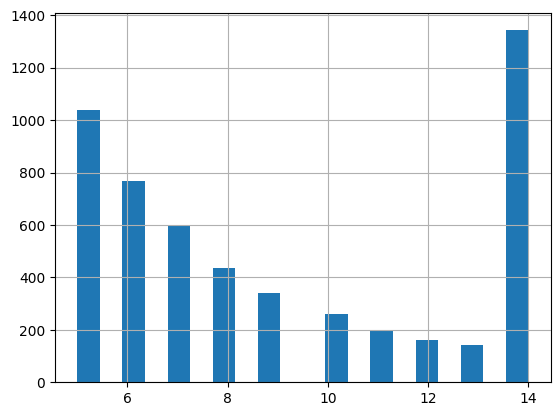

In [39]:
incorrect.word_count.hist(bins=20)

In [40]:
d = predictions_test_df.value_counts('word_count')
for key, value in incorrect.word_count.value_counts().items():
    print(f"WordCount: {key}, % of WordCount: {d[key]/30600*100:.2f}%, % of error in this WordCount: {value/d[key]*100:.2f}%")

WordCount: 14, % of WordCount: 28.58%, % of error in this WordCount: 15.36%
WordCount: 5, % of WordCount: 10.83%, % of error in this WordCount: 31.34%
WordCount: 6, % of WordCount: 8.87%, % of error in this WordCount: 28.29%
WordCount: 7, % of WordCount: 7.36%, % of error in this WordCount: 26.61%
WordCount: 8, % of WordCount: 6.70%, % of error in this WordCount: 21.23%
WordCount: 9, % of WordCount: 5.38%, % of error in this WordCount: 20.64%
WordCount: 10, % of WordCount: 4.51%, % of error in this WordCount: 18.91%
WordCount: 11, % of WordCount: 3.86%, % of error in this WordCount: 16.92%
WordCount: 12, % of WordCount: 3.33%, % of error in this WordCount: 15.72%
WordCount: 13, % of WordCount: 2.88%, % of error in this WordCount: 16.10%


In [41]:
from sklearn.metrics import classification_report

report = classification_report(predictions_test_df['true_labels'], predictions_test_df['predicted_labels'], target_names=names2.values())
print(report)

              precision    recall  f1-score   support

    Egyptian       0.79      0.85      0.82      3599
       Iraqi       0.80      0.78      0.79      3599
    Khaleeji       0.68      0.76      0.72      3594
   Levantine       0.79      0.78      0.79      3598
       Lybia       0.79      0.76      0.78      3599
    Maghrebi       0.84      0.78      0.81      3597
      Sudani       0.85      0.81      0.83      3599

    accuracy                           0.79     25185
   macro avg       0.79      0.79      0.79     25185
weighted avg       0.79      0.79      0.79     25185



In [42]:
accuracies = []
for i in range(0,7):
    l_pred_true = predictions_test_df[(predictions_test_df['predicted_labels'] == i) & (predictions_test_df['true_labels'] == i)]
    accuracies.append(len(l_pred_true) / len(predictions_test_df[predictions_test_df['predicted_labels'] == i]))
for i,acc in enumerate(accuracies):
    print(f"Accuracy for {names2[i]}: {acc:.4f}")

Accuracy for Egyptian: 0.7937
Accuracy for Iraqi: 0.7972
Accuracy for Khaleeji: 0.6843
Accuracy for Levantine: 0.7900
Accuracy for Lybia: 0.7909
Accuracy for Maghrebi: 0.8382
Accuracy for Sudani: 0.8541


<Axes: >

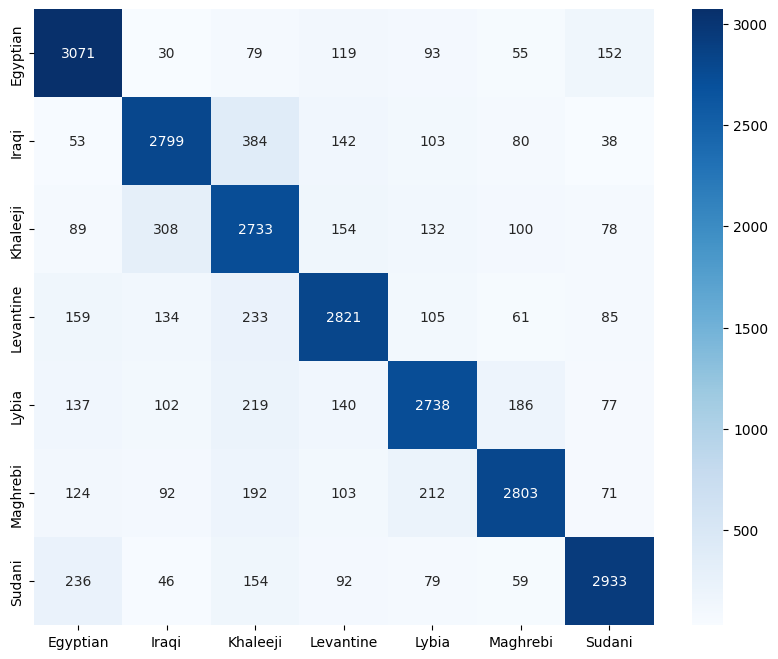

In [43]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(predictions_test_df['true_labels'], predictions_test_df['predicted_labels'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names2.values(), yticklabels=names2.values())